# Network visualization for year 2005
Exploratory data analysis and network visualizations for diplomatic relations for year 2005.

Run `main.py` file first to scrape presidential visits, merge datasets and create a db with data.

## Packages

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# create a plots folder to store plots
import os
if not os.path.exists('./plots/'):
    os.mkdir('./plots')
if not os.path.exists('./plots/networks'):
    os.mkdir('./plots/networks')

# Centrality Ranking
In the following we will examine different centrality measures for the year 2005. 
We first plot the netwowrk's adjacency matrix and examine network statistics. 
We continue by examining correlations between centrality measures and evaluate the use of eigenvector, closeness, betweeness and degree centralities computed on the undirected graph.
We also examine the distribution of each measure as well as the top rankings proposed by each one of them. 

In [3]:
# import our diplomatic_exchanges python script
import diplomatic_exchanges as de

In [4]:
# connect to database and load data for 2005 as a graph
conn = sqlite3.connect('./diplomatic.db')
G = de.get_diplomatic_graph(conn, 2005)

In [5]:
# check some basic network metrics
print('number of edges:', G.size())
print('number of nodes:', len(G.nodes()))
print('density:', nx.density(G))

number of edges: 7470
number of nodes: 192
density: 0.2036976439790576


In [6]:
# adjacency matrix
H = nx.adjacency_matrix(G)
H

<192x192 sparse matrix of type '<class 'numpy.intc'>'
	with 7470 stored elements in Compressed Sparse Row format>

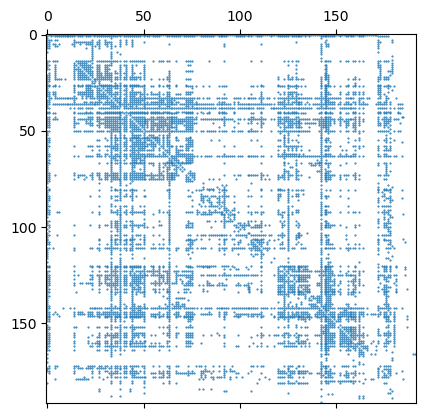

In [7]:
# plot adjacency matrix
fig, ax = plt.subplots(1,1, figsize=(6.4, 4.8))
ax.spy(H, markersize =1, marker = '.')
fig.savefig('./plots/networks/adj_matr_2005.png', dpi=300)

In [8]:
# load centrality measures for year 2005
df_centralities = de.get_centrality_measures(year=2005)
df_centralities

,index,pagerank,katz,eigenvector,betweenness,closeness,degree,in_degree,out_degree,node_id,year
0,24,1.000000,0.966833,0.348819,5.160641e-13,1.0,1.000000,0.948718,1.000000,2,2005
1,48,0.521256,0.804169,0.466178,7.604882e-13,1.0,0.741379,0.621795,0.701754,20,2005
2,73,0.014564,0.033838,0.551500,9.068511e-37,1.0,0.022989,0.025641,0.017544,31,2005
3,104,0.046998,0.124208,0.761892,3.889137e-37,1.0,0.097701,0.070513,0.087719,41,2005
4,147,0.136362,0.229516,0.595980,5.983210e-08,1.0,0.183908,0.185897,0.157895,42,2005
...,...,...,...,...,...,...,...,...,...,...,...
187,1659,0.011548,0.020768,0.524989,3.081700e-37,1.0,0.017241,0.025641,0.011696,760,2005
188,1661,0.000000,0.000000,0.507905,6.907716e-25,1.0,0.022989,0.000000,0.029240,935,2005
189,1663,0.000000,0.000000,0.507905,3.282009e-29,1.0,0.011494,0.000000,0.017544,946,2005
190,1665,0.000000,0.000000,0.507905,0.000000e+00,1.0,0.000000,0.006410,0.000000,947,2005


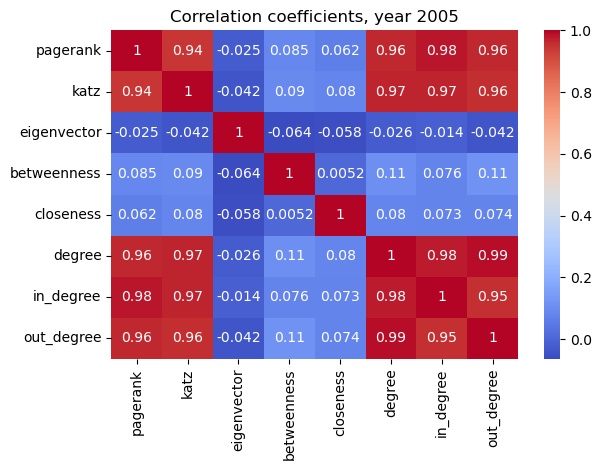

In [64]:
# check for correlation between measures
plt.figure(tight_layout=True)
correlations = df_centralities.drop(['index', 'node_id', 'year'], axis=1).corr()
sns.heatmap(correlations, cmap='coolwarm', annot=True)
plt.title("Correlation coefficients, year 2005")
plt.savefig('./plots/networks/correlation_heatmap_2005.png', dpi=300)

We see that the measures are generally highly correlated with each other

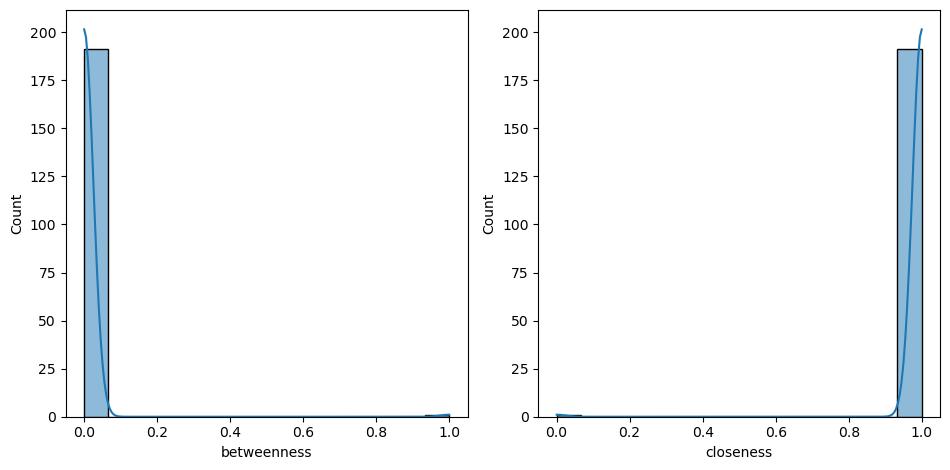

In [10]:
# check betweeness and closeness
# visualize differences
fig, axs = plt.subplots(1,2, figsize=(1.5*6.4, 4.8), tight_layout=True)

for name, ax in zip(['betweenness', 'closeness'], axs.flatten()):
    sns.histplot(df_centralities[name], bins=15, kde=True, ax=ax)

We can see that betweeness and closeness do not produce sensible ranking and thus exclude them from our analysis

In [11]:
# centrality measures to examine
measures = ['pagerank', 'degree', 'eigenvector', 'katz', 'in_degree', 'out_degree']

In [12]:
# load country and country codes mappings
from crawl_and_scrape import COUNTRIES_TO_CODES_DICT, CODES_TO_COUNTRIES_DICT

# abbreviations for better visualization
CODES_TO_COUNTRIES_DICT[2]= "USA"
CODES_TO_COUNTRIES_DICT[200] = "UK"
CODES_TO_COUNTRIES_DICT[490] = "Congo"
CODES_TO_COUNTRIES_DICT[696] = 'Arab Emirates'

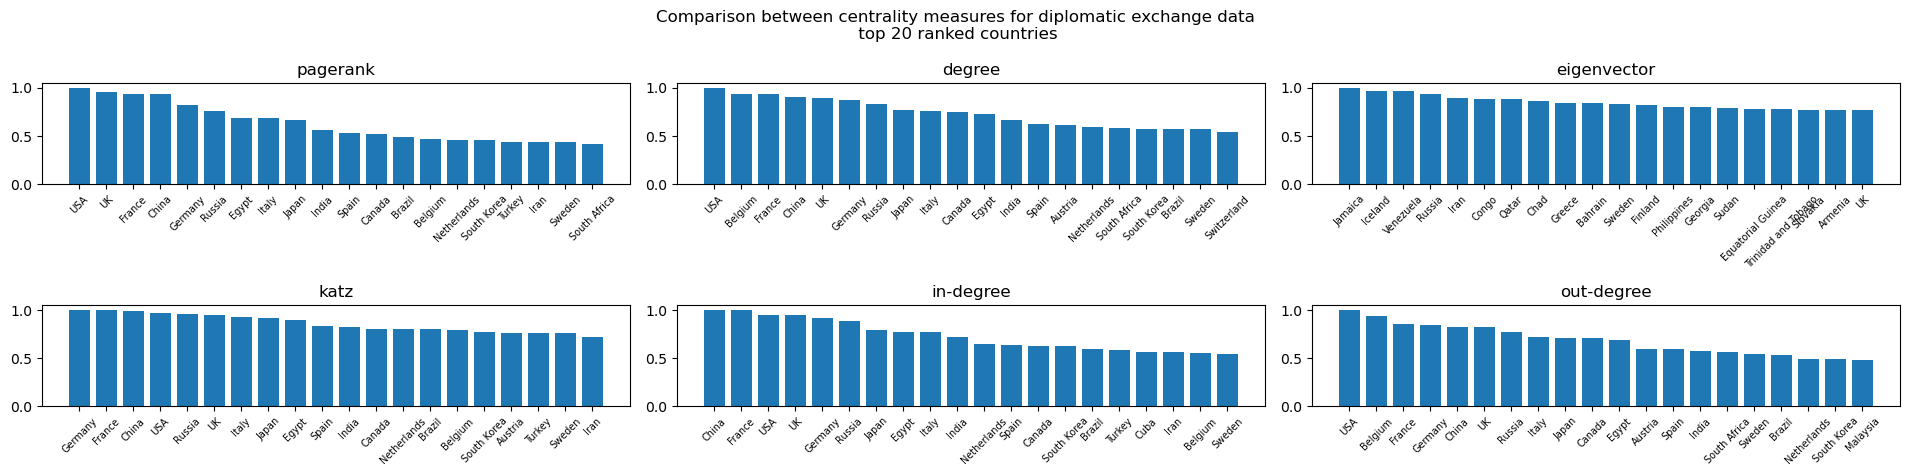

In [13]:
# plot centrality measures for top 20 rankings according to each measure
fig, axs = plt.subplots(2,3, figsize=(3*6.4,4.8), tight_layout=True)

# number of countries to check
limit = 20
for ax, column in zip(axs.flatten(), measures):
    sorted_measures = df_centralities.sort_values(column, ascending=False)
    sorted_measure = sorted_measures[column].values[:limit]
    country_codes = sorted_measures['node_id'].values[:limit]
    country_names = list(map(lambda x: CODES_TO_COUNTRIES_DICT[x], country_codes))
    ax.bar(country_names, sorted_measure)
    ax.set_xticklabels(country_names, rotation=45, fontsize=7);
    ax.set_title(column.replace('_','-'))
fig.suptitle(f"Comparison between centrality measures for diplomatic exchange data\n top {limit} ranked countries")
fig.savefig(f'./plots/networks/2005_comparison_between_measures_top_{limit}.png', dpi=300)

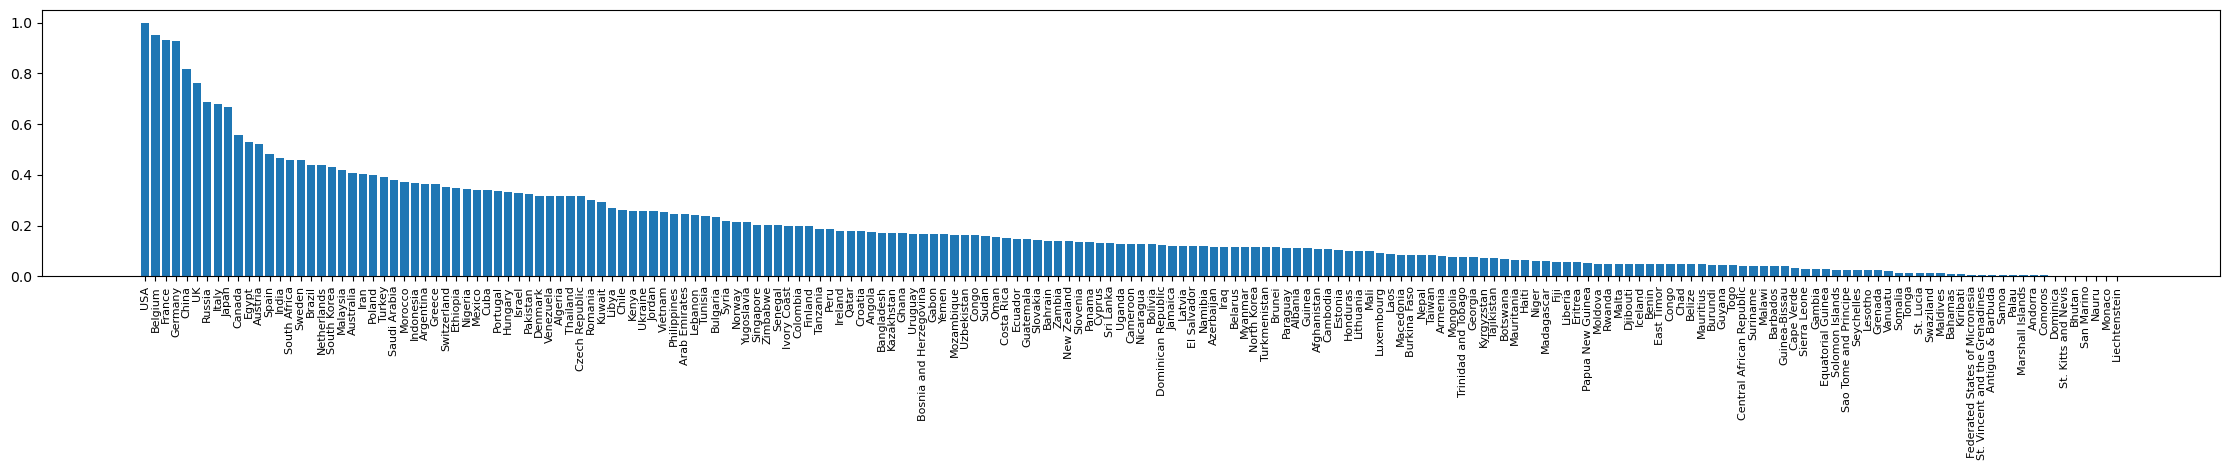

In [14]:
# Pagerank ranking for all countries
fig, ax = plt.subplots(1,1, figsize=(3.5*6.4, 4.8), tight_layout=True)


ax.bar(list(map(lambda x: CODES_TO_COUNTRIES_DICT[x], df_centralities.sort_values('pagerank', ascending=False)['node_id'])), df_centralities.sort_values('pagerank', ascending=False)['pagerank'])
ax.set_xticklabels(list(map(lambda x: CODES_TO_COUNTRIES_DICT[x], df_centralities.sort_values(column, ascending=False)['node_id'])),rotation=90, fontsize=7);
ax.tick_params(axis='x', which='major', labelsize=8)
fig.savefig('./plots/networks/2005_pagerank_weighted.png', dpi=300)

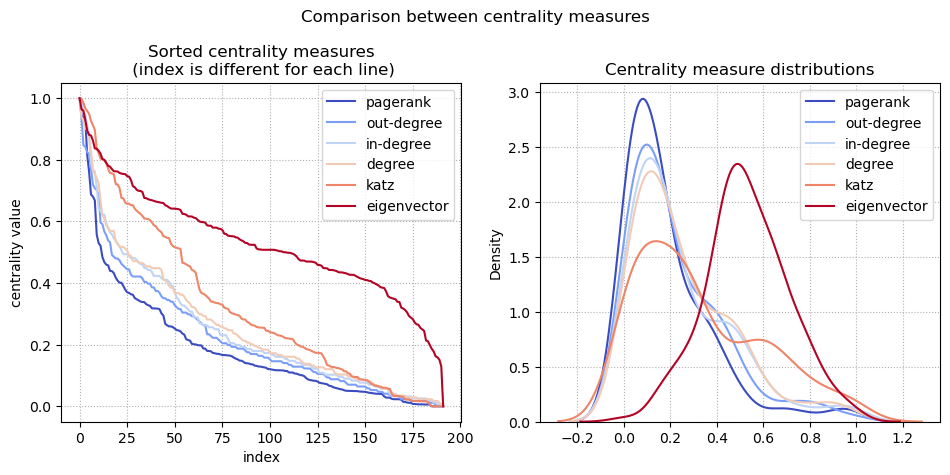

In [63]:
# comparison between sorted measures
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(1.5*6.4, 4.8), tight_layout=True)

# set the colormap and color cycle
cmap = plt.cm.get_cmap('coolwarm')
ax1.set_prop_cycle('color', cmap(np.linspace(0, 1, 6)))
ax2.set_prop_cycle('color', cmap(np.linspace(0, 1, 6)))

# measures to match colors
measures = ['pagerank', 'out_degree', 'in_degree', 'degree', 'katz', 'eigenvector']

for column in measures:
    sorted_measures = df_centralities.sort_values(column, ascending=False)
    sorted_measure = sorted_measures[column].values
    ax1.plot(sorted_measure, label=column.replace('_','-'))
    sns.kdeplot(sorted_measure, label=column.replace('_','-'), ax=ax2)

ax1.legend()
ax1.grid(ls=':')
ax1.set_ylabel('centrality value')
ax1.set_xlabel('index')
ax1.set_title("Sorted centrality measures\n (index is different for each line)");
    
ax2.legend()
ax2.grid(ls=':')
ax2.set_title("Centrality measure distributions");


fig.suptitle("Comparison between centrality measures")
fig.savefig('./plots/networks/comparison_between_measures_2005.png', dpi=300)

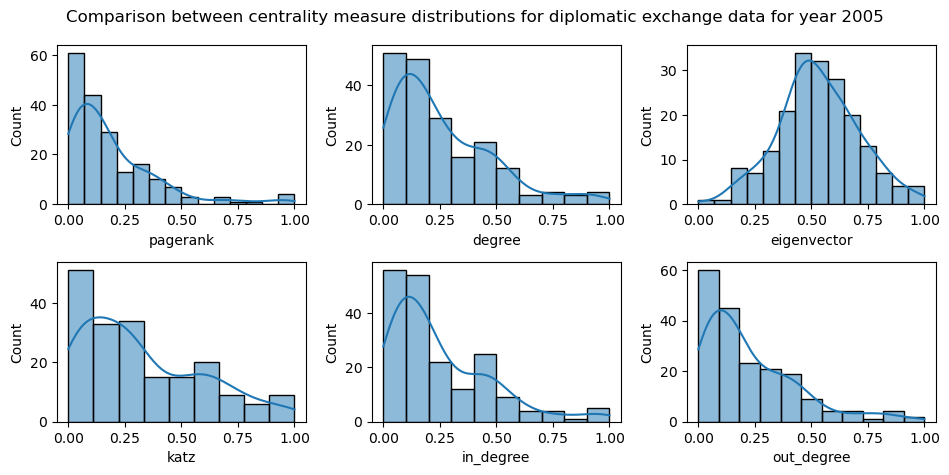

In [17]:
# distributions of centraltiy measures
fig, axs = plt.subplots(2,3, figsize=(1.5*6.4,4.8), tight_layout=True)
limit = 20
# count = 1
for ax, column in zip(axs.flatten(), measures):
    if column=='betweenness':
        sns.histplot(df_centralities[column], ax=ax, kde = True, bins=15)
    else:
        sns.histplot(df_centralities[column], ax=ax, kde = True)
fig.suptitle(f"Comparison between centrality measure distributions for diplomatic exchange data for year 2005")
fig.savefig(f'./plots/networks/2005_comparison_between_measure_distributions.png', dpi=300)

## Network visualizations
In the following we provide some preliminary network visualizations using `networkx` and `pyvis`.
We also dump the 2005 networks in files used by Gephi to improve the network visualizations.

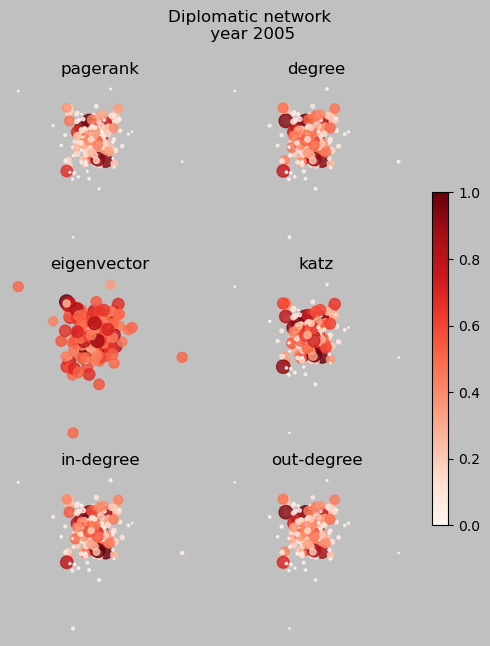

In [18]:
# Comparison between measures in network visualization
fig, axs = plt.subplots(3,2, figsize=( 6.4,1.5* 4.8))#,dpi = 300)

fig.patch.set_facecolor('silver')

# layout = nx.random_layout(G, seed=42)
layout = nx.spring_layout(G, iterations=5, seed=42)
for ax, column in zip(axs.flatten(), measures):
    nx.draw_networkx_nodes(G, pos=layout, node_size = 100*df_centralities[column].values +1,
                           node_color = df_centralities[column].values+1, cmap=plt.cm.Reds, ax=ax, alpha=0.8)
    ax.set_title(column.replace('_','-'))
    ax.axis('off')
    
    
# Add a colorbar to the plot
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=df_centralities[measures].min().min(),
                                                               vmax=df_centralities[measures].max().max()))
sm._A = []
cbar = fig.colorbar(sm, ax=axs, shrink=0.6)
fig.suptitle("Diplomatic network\n year 2005")
fig.savefig("./plots/networks/centrality_comparison_2005_graphs.png", dpi=300)

In the above network visualization we see the 2005 diplomatic exchange network according to different measures of centrality.
Each node's size is computed according the the corresponding centrality value. The bigger the node, the higher the centrality.
The same information is captured additionally by the color scale. The more "red" the node is, the higher its centrality.
Note that edges have been removed to provide a cleaner visualization of the networks.
We observe that pagerank, degree (for the undirected graph), katz, in-degree and out-degree provide similar rankings. Eigenvector seems to be assigning values around the middle of the spectrum as suggested also by its distribution.

### Top 4 nodes
In the following we will visualize the connections of the top 4 pagerank-ranked nodes with the rest of the nodes.

In [19]:
# get the top 4 nodes
top_4_nodes =  df_centralities.sort_values('pagerank',ascending=False)['node_id'].values[:4]

# create an empty graph to populate with the connections of the top nodes
top_4_graph = nx.DiGraph() 

# add the edges between the subset nodes and the rest of the nodes
for node in G.nodes():
    if node in top_4_nodes:
        for neighbor in G.neighbors(node):
            top_4_graph.add_edge(node, neighbor, )
            
# create an empty graph 
# that will contain only the connections to the top 4 nodes
filtered_G = nx.DiGraph()

# add the nodes from the full graph to the filtered graph
for node in G.nodes():
    filtered_G.add_node(node, label=CODES_TO_COUNTRIES_DICT[node])

# add the edges from the subset of edges to the filtered graph
for edge in top_4_graph.edges:
    filtered_G.add_edge(*edge)

## President visits visualization
In the following we will visualize the president's visits in the above-mentioned top4-pagerank-ranked subgraph.

In [20]:
from pyvis.network import Network

In [21]:
# run query to get data for regression analysis from database
conn = sqlite3.connect('diplomatic.db')
data = de.get_data_for_regression(conn, 2005)

In [22]:
# use a binary variable signifying whether the US president visited each country or not
# 1: the president visited
# 0: the president did NOT visit
data['president_visit_binary'] = data['destination country'].map(lambda x: 0 if x is None else 1)

In [25]:
# top 4 nodes network visualization with pyvis and presidential visits
net = Network(height='700px', select_menu=True, width='100%', bgcolor='#222222', font_color='white')

presidential_visit_nodes = data[data.president_visit_binary == 1].node_id.values

graph_for_viz = filtered_G
net.from_nx(graph_for_viz)

for node in graph_for_viz.nodes:
    if node in top_4_nodes:
        net.add_node(str(node), label=str(CODES_TO_COUNTRIES_DICT[node]), color="#f21f1f")
    elif node in presidential_visit_nodes:
        net.add_node(str(node), label=str(CODES_TO_COUNTRIES_DICT[node]), color="#8e199c")
    else:
        net.add_node(str(node), label=str(CODES_TO_COUNTRIES_DICT[node]), color='#1a7599')
for edge in graph_for_viz.edges():
    net.add_edge(str(edge[0]), str(edge[1]))    
    
net.show_buttons(filter_=['physics', 'nodes'])
net.show("plots/networks/top_4_pagerank_nodes_graph_2005_showing_presidential_visits.html")

# Gephi dumps
Finally we dump both the complete 2005 graph and the graph containing the connections of the top 4 pagerank-ranked countries to `.gexf` to be visualized

In [26]:
# complete 2005 network Gephi dump
G_with_info = nx.DiGraph()

for node in G.nodes:
    G_with_info.add_node(node, label=CODES_TO_COUNTRIES_DICT[node])
for edge in G.edges:
    G_with_info.add_edge(*edge)

nx.write_gexf(G_with_info, "./plots/networks/complete_network_2005.gexf")

In [27]:
# top 4 pagerank nodes 2005 network Gephi dump
G_with_info = nx.DiGraph()

for node in filtered_G.nodes:
    G_with_info.add_node(node, label=CODES_TO_COUNTRIES_DICT[node])
for edge in filtered_G.edges:
    G_with_info.add_edge(*edge)

nx.write_gexf(G_with_info, "./plots/networks/top4pagerank_network_2005.gexf")